<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Комментарий ревьюера</b>


Привет, Андрей! Давай знакомиться! Меня зовут Дмитрий Махортов, и я буду проверять твой проект. Сразу предлагаю общение на «ты» 🙂, но если тебе это не комфортно, то дай знать, и мы перейдем на «вы». 


Моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе погрузиться в увлекательный мир работы с данными и вырасти в крепкого профи. Это отдаленная цель. А ближайшая - сделать твою работу еще лучше )).
   
    
Все ключевые этапы в работе выполнены, и я вижу что с проектом ты справшяешься. Есть моменты, которые нужно доработать, но я уверен, у тебя все получится.
        
Расскажу как обычно проходит проверка:    
Бывают моменты, которые требуют пристального внимания. Комментарии по ним выделены <span style='background-color:#F7B3A4'> красным цветом </span> и обозначены значком 🛑. После их доработки проект будет принят.  🙂
 
<span style='background-color:#B7EBA7'> Зеленым цветом </span> и значком ✅ отмечены удачные и элегантные решения, на которые можно опираться в будущих проектах. Или советы «со звездочкой», которые помогут тебе в будущем.

<span style='background-color:#F9EDA6'>Жёлтым цветом </span> и значком ⚠️ выделено то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас (однако это не обязательно).

Давай работать над проектом в диалоге: **если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом**. Выбери для своих комментариев какой-то заметный цвет, так мне будет легче отследить изменения. Пожалуйста, **не перемещай, не изменяй и не удаляй мои комментарии**. Всё это поможет выполнить повторную проверку твоего проекта оперативнее. 
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>образец комментария студента</b></font>
   
Можешь использовать этот комментарий. Просто удали этот текст и вместо него напиши свой 🙂

</div>

# Прекод

# Сборный проект-5

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [155]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import os
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import contractions
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, все нужные библиотеки импортированы в начале ноутбука.Это хорошая практика.</div>


<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Но по логике вначале должен быть заголовок и описание, а уже первая кодовая ячейка - это импорты.
    
    
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исправил

</div>

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 Да, это хорошая практика - дать описание контекста и проблемы, которую мы решаем. </div>

In [83]:
DATA_PATH = os.path.expanduser('~/sb5/dsplus_integrated_project_4/to_upload/')
train_data = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'))
crowd_data = pd.read_csv(os.path.join(DATA_PATH, 'CrowdAnnotations.tsv'),
                             header=None, 
                             sep='\t', 
                             names=['image', 'query_id', 'prc', 'quantity_say_yes', 'quantity_say_no'])
expert_data = pd.read_csv(os.path.join(DATA_PATH, 'ExpertAnnotations.tsv'),
                          header=None,
                          sep='\t',
                          names=['image', 'query_id', 'grade_1', 'grade_2', 'grade_3'])
test_data = pd.read_csv((os.path.join(DATA_PATH, 'test_queries.csv')), sep='|')                   

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Очень "больная тема" - это загрузка данных и использование путей.Очевидно, что на моей машине (и скорее всего машине любого другого пользователя) пути к данным будут другие. И это "рабочая ситуация для большинства проектов. Решается она следующим образом:
 
    
  - Путь к директории с данными  должен быть задан в константе, в самом начале работы. Тогда ревьюеру (или любому другому пользователю твоего ноутбука, даже тебе самому, если нужно будет провести презентацию руководителю на другом компьютере) нужно будет изменить только этот путь.
  - Все остальные пути внутри ноутбука должны быть созданы с исопользованием этой константы, а не заданы жестко (есть сленговое определение "хардкод").  Более  того, настоятельно рекомендую для создания сложных путей вместо простой конкатерации строк с исползованием '/' использовать os.path.join(), тогда код будет одинаково надежно работать и в среде Windows и Linux (MacOS).
   
Чтобы запустить твой код при проверке я был вынужден руками менять пути по всему ноутбуку. Прошу тебя внести изменения так, чтобы путь к данным нужно было изменять всего один раз.


А вот это образец универсального кода для загрузки данных    
    
    DATA_PATH = твой путь    
    
    df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'))
    ....
    
    
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исправил

</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Как правило функции создаются для того, чтобы можно было переиспользовать код в других местах.  Но эта функция слишком специфичная, врядли где-то еще можно будет её использовать. А  тогда есть ли смысл её выделять?</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исправил

</div>

In [84]:
train_data.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [85]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [86]:
train_data['image'].nunique()

1000

In [87]:
crowd_data.head()

,image,query_id,prc,quantity_say_yes,quantity_say_no
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [88]:
crowd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             47830 non-null  object 
 1   query_id          47830 non-null  object 
 2   prc               47830 non-null  float64
 3   quantity_say_yes  47830 non-null  int64  
 4   quantity_say_no   47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [89]:
crowd_data['image'].nunique()

1000

In [90]:
expert_data.head()

,image,query_id,grade_1,grade_2,grade_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [91]:
expert_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   grade_1   5822 non-null   int64 
 3   grade_2   5822 non-null   int64 
 4   grade_3   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [92]:
expert_data['image'].nunique()

1000

In [93]:
test_data = test_data.drop(columns=['Unnamed: 0'], axis=1)
test_data.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [94]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


In [95]:
test_data['image'].nunique()

100

In [96]:
expert_data.head()

,image,query_id,grade_1,grade_2,grade_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [97]:
# отфильтровываем строки где эксперты разошлись во мнении
filtered_expert_data = expert_data[expert_data[['grade_1', 'grade_2', 'grade_3']].nunique(axis=1) !=3]
filtered_expert_data

,image,query_id,grade_1,grade_2,grade_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Да, интересное решение с поиском строк, где все эксперты разошлись во мнении</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Обрати внимание, первая строчка с созданием num_unique_grade у тебя дублируется.</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исправил

</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Не согласен с переходом от шкалы оценок (1-4) к бинарным оценкам (0-1).  Тем самым мы теряем важные нюансы, на которых могла бы учиться наша модель. Ведь не зря экспертных оценок у нас мало, похоже они проходили специальное обучение, чтобы ставить более качественные оценки. А ты сводишь их до уровня простого "ДА/НЕТ".</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исправил

</div>

In [98]:
# объединяем экспертные оценки и полученные от краудсорсинга 
merged_data = pd.merge(filtered_expert_data, crowd_data, on=['image', 'query_id'], how='left')
merged_data

,image,query_id,grade_1,grade_2,grade_3,prc,quantity_say_yes,quantity_say_no
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.000000,0.0,3.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0.000000,0.0,3.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,NaN,NaN,NaN
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,NaN,NaN,NaN
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
5691,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,NaN,NaN,NaN
5692,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,0.000000,0.0,3.0
5693,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,0.000000,0.0,3.0
5694,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,NaN,NaN,NaN


In [99]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             5696 non-null   object 
 1   query_id          5696 non-null   object 
 2   grade_1           5696 non-null   int64  
 3   grade_2           5696 non-null   int64  
 4   grade_3           5696 non-null   int64  
 5   prc               2258 non-null   float64
 6   quantity_say_yes  2258 non-null   float64
 7   quantity_say_no   2258 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 356.1+ KB


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
   
    
В этом проекте есть несколько возможных стратегий работы с обучающими и краудсорс оценками,  вот эти стратегии с плюсами и минусами:
   
    
 - использовать соединение через outer, в этом случае, при корректной обработке пропусков мы можем получить более 50К размеченых пар. К плюсам данного подхода можно отнести большое количество данных. Минус - в основном это будут данные, размеченные краудсорсерами, а там качество раметки ниже.
 - использовать только экспертные оценки. плюс - высокое качество данных (разметка имеет шкалу). Минус - данных меньше.  Поясню по поводу качества разметки на примере: если на изображении одна собака, а в описании "две собаки бегут по берегу", то эксперты поставять соответствие 0,6-0,7 (переводя в шкалу 0-1), а краудсорсеры поставят 0.  Но на экспертных оценках модель хотя-бы научится находить собак, а на краудсор оценках ничему не начится.
    
 - использование соединения через left.  Данный подход очевидно проигрывает второму варианту: данных столько же, нужно дополнительно возиться с объединением, но качество разметки снижается.. Но это соответсвует предложениям авторов проекта, поэтому такой подход имеет право на жизнь
    
 - объединение через inner. Тут все плохо - и данных ОЧЕНЬ мало (в два раза меньше, чем использовать только экспертные оценки) и качество у них "подпорчено". И навыков по обработке пропусков не получаем.....
    
Сейчас ты соединил экспертные и краудсорс оценки, но т.к. использован `inner`, то мы просто потеряли половину данных, не получив ничего в замен (точнее только ухудшив наши оценки).
    
Пожалуйста используй любую другую стратегию, кроме внутреннего соединения. Слишком мало данных при этом получается.
    
-------------------
    
Если ты все-таки захочешь использовать бинарные оценки и соответственно решать задачу классификации (что противоречит рекомендациям авторов проекта), то тогда уж можно использовать соединение через outer и работать с 50К размеченных пар.    
    


</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исправил

</div>

In [100]:
def calculate_grade(x):
    if x == 1:
        return 0
    elif x == 2:
        return 1/9
    elif x ==3:
        return 2/9
    else:
        return 3/9

In [101]:
merged_data['grade_1_prc'] = merged_data['grade_1'].map(calculate_grade)
merged_data['grade_2_prc'] = merged_data['grade_2'].map(calculate_grade)
merged_data['grade_3_prc'] = merged_data['grade_3'].map(calculate_grade)
merged_data['exp_prc'] = merged_data['grade_1_prc'] + merged_data['grade_2_prc'] + merged_data['grade_3_prc']
merged_data['crowd_prc'] = merged_data['prc']
merged_data

,image,query_id,grade_1,grade_2,grade_3,prc,quantity_say_yes,quantity_say_no,grade_1_prc,grade_2_prc,grade_3_prc,exp_prc,crowd_prc
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.000000,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0.000000,0.0,3.0,0.000000,0.000000,0.111111,0.111111,0.000000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,NaN,NaN,NaN,0.000000,0.000000,0.111111,0.111111,NaN
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,NaN,NaN,NaN,0.000000,0.111111,0.111111,0.222222,NaN
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,NaN,NaN,NaN,0.000000,0.000000,0.111111,0.111111,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5691,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN
5692,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,0.000000,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000
5693,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,0.000000,0.0,3.0,0.000000,0.000000,0.111111,0.111111,0.000000
5694,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN


In [102]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             5696 non-null   object 
 1   query_id          5696 non-null   object 
 2   grade_1           5696 non-null   int64  
 3   grade_2           5696 non-null   int64  
 4   grade_3           5696 non-null   int64  
 5   prc               2258 non-null   float64
 6   quantity_say_yes  2258 non-null   float64
 7   quantity_say_no   2258 non-null   float64
 8   grade_1_prc       5696 non-null   float64
 9   grade_2_prc       5696 non-null   float64
 10  grade_3_prc       5696 non-null   float64
 11  exp_prc           5696 non-null   float64
 12  crowd_prc         2258 non-null   float64
dtypes: float64(8), int64(3), object(2)
memory usage: 578.6+ KB


In [103]:
merged_data['crowd_prc'] = merged_data['crowd_prc'].fillna(merged_data['exp_prc'])
merged_data['final_prc'] = merged_data['exp_prc'] * 0.6 + merged_data['crowd_prc'] * 0.4
merged_data

,image,query_id,grade_1,grade_2,grade_3,prc,quantity_say_yes,quantity_say_no,grade_1_prc,grade_2_prc,grade_3_prc,exp_prc,crowd_prc,final_prc
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.000000,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0.000000,0.0,3.0,0.000000,0.000000,0.111111,0.111111,0.000000,0.066667
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,NaN,NaN,NaN,0.000000,0.000000,0.111111,0.111111,0.111111,0.111111
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,NaN,NaN,NaN,0.000000,0.111111,0.111111,0.222222,0.222222,0.222222
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,NaN,NaN,NaN,0.000000,0.000000,0.111111,0.111111,0.111111,0.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5691,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5692,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,0.000000,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5693,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,0.000000,0.0,3.0,0.000000,0.000000,0.111111,0.111111,0.000000,0.066667
5694,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [104]:
df = merged_data[['image', 'query_id', 'final_prc']]
df

,image,query_id,final_prc
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.066667
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111
...,...,...,...
5691,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,0.000000
5692,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,0.000000
5693,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,0.066667
5694,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,0.000000


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Чтобы не путаться между датафреймами настойчиво советую закончить всё колдовство по соединению датафреймов в этом разделе.

Сейчас у тебя уже есть датафрейм с парами (изображение + описание)  и оценкой соотвтствия. В принципе на этих данных мы могли бы уже учить модели, не хватает только восстановить текстовое описание по query_id. Сделай это сейчас и все дальнейшие операции (чистку, векторизацию и т.д.) можно вести уже с этим основным датафреймом. 
</div>

In [105]:
df_final = pd.merge(df, train_data, on=['image', 'query_id'], how='left')
df_final.head()

,image,query_id,final_prc,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000,A young child is wearing blue goggles and sitt...
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.066667,A girl wearing a yellow shirt and sunglasses s...
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111,A man sleeps under a blanket on a city street .
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222,A woman plays with long red ribbons in an empt...
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111,Chinese market street in the winter time .


In [106]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5696 non-null   object 
 1   query_id    5696 non-null   object 
 2   final_prc   5696 non-null   float64
 3   query_text  5696 non-null   object 
dtypes: float64(1), object(3)
memory usage: 178.1+ KB


<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исправил

</div>

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [107]:
df_final['query_text'].unique()

array(['A young child is wearing blue goggles and sitting in a float in a pool .',
       'A girl wearing a yellow shirt and sunglasses smiles .',
       'A man sleeps under a blanket on a city street .',
       'A woman plays with long red ribbons in an empty square .',
       'Chinese market street in the winter time .',
       'A soccer ball is above the head of a man wearing black shorts and red and black striped shirt .',
       'A young boy dressed in a red uniform kicks the soccer ball on the field as another child in blue watches from behind .',
       'A man and woman look back at the camera while standing in front of a red art structure .',
       'A white dog jumps to catch a blue ball in a living room .',
       'A little boy shakes the snow off of a tree .',
       'The kid is on a float in the snow .',
       'Two long-haired puppy dogs have a romp in the snow .',
       'A little girl wearing sunglasses puts her feet into the kitchen sink .',
       'Snowboarder in the a

In [108]:
child_keywords = [
    "baby", "kid", "kiddie", "toddler", "young", "youth", "boy", "girl",
    "teenage", "teenager", "school", "playground", "toy", "birthday",
    "child", "nursery", "junior", "infant", "preschool", "pupil",
    "student", "little"
]

In [109]:
def filter_images(df, keywords):
    bad_comments = df[df['query_text'].str.contains('|'.join(keywords), case=False, na=False)]
    bad_images = set(bad_comments['query_id'].str[:-2])
    return df[~df['query_id'].str[:-2].isin(bad_images)]

In [110]:
df_filtered_no_child = filter_images(df_final, child_keywords)
df_filtered_no_child

,image,query_id,final_prc,query_text
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111,A man sleeps under a blanket on a city street .
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222,A woman plays with long red ribbons in an empt...
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111,Chinese market street in the winter time .
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,0.000000,A soccer ball is above the head of a man weari...
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.066667,A man and woman look back at the camera while ...
...,...,...,...,...
5691,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,0.000000,People trackside at a subway station by a train .
5692,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,0.000000,A man sitting on a subway .
5693,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,0.066667,A man wearing a red hat looks down as another ...
5694,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,0.000000,A white birds lands swiftly in the water .


In [111]:
df_filtered_no_child.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4013 entries, 2 to 5695
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       4013 non-null   object 
 1   query_id    4013 non-null   object 
 2   final_prc   4013 non-null   float64
 3   query_text  4013 non-null   object 
dtypes: float64(1), object(3)
memory usage: 156.8+ KB


<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
    
Ты удаляешь комментарии, в которых есть слова, обозначающие детей. Но наша задача убрать изображения, содержащие детей. Есть два способа сделать это:
    
 - Определить список плохих изображений, как изображения удовлетворяющие условиям:
    - Комментарий содержит плохие слова
    - <b>Оценка соответствия комментария и изображения выше порога.</b>
 - Удалить из нашего датасета все пары "изображение/описание" с плохими изображениями.
    
 
И второй, очень красивый способ. Он основан на том, что `query_id` содержит в с себе имя изображения, для которого он был написан (такая пасхалочка от авторов датасета).
    
 - Определить список плохих комментариев
 - У `query_id`  плохих комментариев отрезать два последних символа и получим список плохих изображений.
    
    
    
    
    
</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
И давай поймем, с каким датасетом ты все-таки работаешь?  В предущем разделе ты получил final_data, здесь начинаеш чистить  train_data.  Конечно можно и так, но это ведет во первых к лишним вычислениям при векторизации, а потом и к ошибкам на этапе объединения.</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исправил

</div>

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [112]:
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(*list(model.children())[:-1])

In [113]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [114]:
def extract_vector(image_path):
    image = Image.open(image_path).convert('RGB') 
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        vector = model(image).flatten().numpy()  
    return vector

In [115]:
image_folder = os.path.join(DATA_PATH, 'train_images')
data = []

for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    try:
        vector = extract_vector(image_path) 
        data.append({'image_name': image_name, 'vector': vector})  
    except Exception as e:
        print(f"Ошибка обработки изображения {image_name}: {e}") 

In [116]:
df_vectors = pd.DataFrame(data)
df_vectors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  1000 non-null   object
 1   vector      1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [117]:
df_vectors

,image_name,vector
0,1056338697_4f7d7ce270.jpg,"[0.91964084, 1.0021442, 0.85269105, 1.0983472,..."
1,106490881_5a2dd9b7bd.jpg,"[0.9387735, 0.920311, 0.8802685, 1.060116, 0.9..."
2,1082379191_ec1e53f996.jpg,"[0.9419994, 0.9627958, 0.96457094, 1.0773449, ..."
3,1084040636_97d9633581.jpg,"[0.90549934, 0.93805265, 0.88626117, 1.0268164..."
4,1096395242_fc69f0ae5a.jpg,"[0.9073575, 1.0056148, 0.91352606, 1.0409794, ..."
...,...,...
995,929679367_ff8c7df2ee.jpg,"[0.8399102, 0.9876094, 0.911266, 1.0225055, 0...."
996,96420612_feb18fc6c6.jpg,"[0.8551315, 0.92710495, 0.83983976, 1.0169395,..."
997,968081289_cdba83ce2e.jpg,"[0.8736879, 1.0514147, 0.9467105, 1.0570235, 0..."
998,979383193_0a542a059d.jpg,"[0.8976456, 0.96289396, 0.9138334, 0.9914297, ..."


In [118]:
array_data = np.array(df_vectors['vector'].tolist()) 
df_features = pd.DataFrame(array_data, columns=[f"feature_{i}" for i in range(array_data.shape[1])])
df_features

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_502,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511
0,0.919641,1.002144,0.852691,1.098347,0.980259,0.915392,0.909769,1.201789,0.890275,0.926658,...,0.925125,0.838970,0.955245,0.898911,1.149247,0.983851,0.936671,0.897938,1.017677,0.947832
1,0.938774,0.920311,0.880269,1.060116,0.912927,0.903818,0.963944,1.147150,0.946498,0.963630,...,0.974439,0.898665,0.919451,0.945660,1.093673,1.073331,0.957134,0.933515,1.152811,1.000563
2,0.941999,0.962796,0.964571,1.077345,0.947505,0.888702,0.927942,1.205341,0.923095,0.925544,...,0.900896,0.914692,0.880179,0.883210,1.066052,0.983562,0.928565,0.960588,1.018096,0.977845
3,0.905499,0.938053,0.886261,1.026816,0.954718,0.964169,1.005523,1.143940,1.004841,0.901848,...,0.936569,0.909874,0.924532,0.911100,1.041825,1.005583,0.958541,0.908590,1.044639,1.013438
4,0.907358,1.005615,0.913526,1.040979,0.869785,0.866668,0.898260,1.180710,0.967873,1.004275,...,0.963517,0.915005,0.920481,0.885751,1.058987,0.928345,0.964561,0.958221,1.018782,0.979316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.839910,0.987609,0.911266,1.022506,0.943395,0.861341,0.923484,1.162398,1.032690,1.053403,...,0.917459,0.935590,0.814498,0.944867,1.088055,1.045631,0.963814,0.965471,1.084973,0.959560
996,0.855132,0.927105,0.839840,1.016940,0.877030,0.833393,0.921180,1.142151,0.989365,0.937704,...,0.910195,0.910780,0.964557,0.824723,1.117979,0.937097,0.960165,0.975468,1.087360,0.990746
997,0.873688,1.051415,0.946711,1.057024,0.935734,0.858853,0.953969,1.202177,0.858476,0.971056,...,0.935888,0.926760,0.936558,0.887519,1.075046,1.037196,0.902958,0.863603,1.097341,0.929419
998,0.897646,0.962894,0.913833,0.991430,0.962638,0.844230,1.000184,1.228233,0.877553,0.890624,...,0.937576,0.821707,0.916567,0.887169,1.129156,1.068258,0.940294,0.889565,1.078078,1.013186


In [119]:
df_image_features = pd.concat([df_vectors, df_features], axis=1)
df_image_features.drop(columns=['vector'], axis=1, inplace=True)
df_image_features

,image_name,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_502,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511
0,1056338697_4f7d7ce270.jpg,0.919641,1.002144,0.852691,1.098347,0.980259,0.915392,0.909769,1.201789,0.890275,...,0.925125,0.838970,0.955245,0.898911,1.149247,0.983851,0.936671,0.897938,1.017677,0.947832
1,106490881_5a2dd9b7bd.jpg,0.938774,0.920311,0.880269,1.060116,0.912927,0.903818,0.963944,1.147150,0.946498,...,0.974439,0.898665,0.919451,0.945660,1.093673,1.073331,0.957134,0.933515,1.152811,1.000563
2,1082379191_ec1e53f996.jpg,0.941999,0.962796,0.964571,1.077345,0.947505,0.888702,0.927942,1.205341,0.923095,...,0.900896,0.914692,0.880179,0.883210,1.066052,0.983562,0.928565,0.960588,1.018096,0.977845
3,1084040636_97d9633581.jpg,0.905499,0.938053,0.886261,1.026816,0.954718,0.964169,1.005523,1.143940,1.004841,...,0.936569,0.909874,0.924532,0.911100,1.041825,1.005583,0.958541,0.908590,1.044639,1.013438
4,1096395242_fc69f0ae5a.jpg,0.907358,1.005615,0.913526,1.040979,0.869785,0.866668,0.898260,1.180710,0.967873,...,0.963517,0.915005,0.920481,0.885751,1.058987,0.928345,0.964561,0.958221,1.018782,0.979316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,929679367_ff8c7df2ee.jpg,0.839910,0.987609,0.911266,1.022506,0.943395,0.861341,0.923484,1.162398,1.032690,...,0.917459,0.935590,0.814498,0.944867,1.088055,1.045631,0.963814,0.965471,1.084973,0.959560
996,96420612_feb18fc6c6.jpg,0.855132,0.927105,0.839840,1.016940,0.877030,0.833393,0.921180,1.142151,0.989365,...,0.910195,0.910780,0.964557,0.824723,1.117979,0.937097,0.960165,0.975468,1.087360,0.990746
997,968081289_cdba83ce2e.jpg,0.873688,1.051415,0.946711,1.057024,0.935734,0.858853,0.953969,1.202177,0.858476,...,0.935888,0.926760,0.936558,0.887519,1.075046,1.037196,0.902958,0.863603,1.097341,0.929419
998,979383193_0a542a059d.jpg,0.897646,0.962894,0.913833,0.991430,0.962638,0.844230,1.000184,1.228233,0.877553,...,0.937576,0.821707,0.916567,0.887169,1.129156,1.068258,0.940294,0.889565,1.078078,1.013186


## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [120]:
nlp = spacy.load("en_core_web_sm")

In [121]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a.kuznecov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [122]:
def lematize_text(text):
    expanded_text = contractions.fix(text)
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', expanded_text).lower().replace('\n', ' ').replace('\r', ' ').replace('  ', ' ')
    doc = nlp(cleaned_text)
    lemmas = [token.lemma_ for token in doc]
    filtered_tokens = [word for word in lemmas if word not in stop_words]
    return " ".join(filtered_tokens)  

In [123]:
df_filtered_lemmas = df_filtered_no_child.copy()
df_filtered_lemmas['lemmatized_text'] = df_filtered_lemmas['query_text'].apply(lematize_text)

In [124]:
df_filtered_lemmas.reset_index(drop=True, inplace=True)
df_filtered_lemmas

,image,query_id,final_prc,query_text,lemmatized_text
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111,A man sleeps under a blanket on a city street .,man sleep blanket city street
1,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222,A woman plays with long red ribbons in an empt...,woman play long red ribbon empty square
2,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111,Chinese market street in the winter time .,chinese market street winter time
3,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,0.000000,A soccer ball is above the head of a man weari...,soccer ball head man wear black short red blac...
4,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.066667,A man and woman look back at the camera while ...,man woman look back camera stand front red art...
...,...,...,...,...,...
4008,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,0.000000,People trackside at a subway station by a train .,people trackside subway station train
4009,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,0.000000,A man sitting on a subway .,man sit subway
4010,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,0.066667,A man wearing a red hat looks down as another ...,man wear red hat look another man watch
4011,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,0.000000,A white birds lands swiftly in the water .,white bird land swiftly water


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Долго не мог понять, почему из 4095 записей в датафрейме у  тебя вдруг получается 2975 векторов признаков.

Оказалось что ошибка происходит в этой ячейке. Ты просто теряешь очень много данных при лемматизации. Твой код предполагает, что индексы идут по порядку, но в датафрейме train_data_filtered это совсем не так (((. Как следствие около четверти текстов не были лемматизированы и мы просто не подсчитали для них эмбеддинги.
    
-------------------------
    
Советую вообще отказаться от "ручных" циклов в итерации по датафрейму и использовать apply.  А если очень нужен прогресс-бар,то можно использовать progres_apply
    
```python
from tqdm.notebook import tqdm
tqdm.pandas()

data['lemm_text'] = data['text'].progress_apply(lemmafunction)    
```    
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исправил

</div>

In [125]:
df_filtered_lemmas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4013 entries, 0 to 4012
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            4013 non-null   object 
 1   query_id         4013 non-null   object 
 2   final_prc        4013 non-null   float64
 3   query_text       4013 non-null   object 
 4   lemmatized_text  4013 non-null   object 
dtypes: float64(1), object(4)
memory usage: 156.9+ KB


In [126]:
corpus = df_filtered_lemmas['lemmatized_text']
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)
tfidf_matrix.shape

(4013, 932)

In [127]:
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out()
)
tfidf_df

,across,action,actor,adult,aerial,aerodynamically,aged,ahead,air,airborne,...,wooden,woodland,woodstacke,word,wrestle,wrinkle,write,yard,yellow,yerba
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4013 entries, 0 to 4012
Columns: 932 entries, across to yerba
dtypes: float64(932)
memory usage: 28.5 MB


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
    
Общая рекомендация по этому разделу: при выполнении сложных преобразований датафреймов всегда старайся проверять, что находится в объединяемых датафреймах  обязательно смотри что получилось после операции объединения (первые строки датафрейма, последние строки датафрейма, а также info(). 
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исправил

</div>

In [129]:
df_tfidf_features = pd.concat([df_filtered_lemmas, tfidf_df], axis=1)
df_tfidf_features.drop(columns=['query_text', 'lemmatized_text'], axis=1, inplace=True)
df_tfidf_features

,image,query_id,final_prc,across,action,actor,adult,aerial,aerodynamically,aged,...,wooden,woodland,woodstacke,word,wrestle,wrinkle,write,yard,yellow,yerba
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4008,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4009,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4010,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4011,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
    
Объедиение датафреймов произведено с ошибкой. проблема в том, что у датафреймов разные индексы, а значит добавятся недостающие строки, а недостающие значения будут заполнены NaN </div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исправил

</div>

In [130]:
merged_final_df = pd.merge(df_tfidf_features, df_image_features, left_on='image', right_on='image_name', how='inner')
merged_final_df

,image,query_id,final_prc,across,action,actor,adult,aerial,aerodynamically,aged,...,feature_502,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.925125,0.838970,0.955245,0.898911,1.149247,0.983851,0.936671,0.897938,1.017677,0.947832
1,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.925125,0.838970,0.955245,0.898911,1.149247,0.983851,0.936671,0.897938,1.017677,0.947832
2,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.925125,0.838970,0.955245,0.898911,1.149247,0.983851,0.936671,0.897938,1.017677,0.947832
3,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.925125,0.838970,0.955245,0.898911,1.149247,0.983851,0.936671,0.897938,1.017677,0.947832
4,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.925125,0.838970,0.955245,0.898911,1.149247,0.983851,0.936671,0.897938,1.017677,0.947832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4008,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.909531,0.962339,0.889663,0.808352,1.154285,1.006485,0.950458,0.921330,1.128105,0.989778
4009,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.909531,0.962339,0.889663,0.808352,1.154285,1.006485,0.950458,0.921330,1.128105,0.989778
4010,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.909531,0.962339,0.889663,0.808352,1.154285,1.006485,0.950458,0.921330,1.128105,0.989778
4011,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.909531,0.962339,0.889663,0.808352,1.154285,1.006485,0.950458,0.921330,1.128105,0.989778


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">

К сожалению здесь тоже ошибка.

Объект, для которого существует оценка - это ПАРА избражение + описание. Поэтому соединение нужно использовать используя именно ПАРУ в качестве ключа.  А сейчас ты используеьшь в качестве ключа query_id, из за чего датасет после соединения вдруг разросся до 16 тысяч записей (хотя я у тебя сейчас всего 2258 оценок).    
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исправил

</div>

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [131]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, valid_indices = next(gss.split(X=merged_final_df.drop(columns=['final_prc', 'image_name']), 
                                             y=merged_final_df['final_prc'], 
                                             groups=merged_final_df['image']))
train_df, valid_df = merged_final_df.loc[train_indices], merged_final_df.loc[valid_indices]

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, благодаря использованию GroupShuffleSplit ты исключаешь попадание одного изображения в обучающий и валидационный наборы.</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Только давай разберемся с выборками. Финальное тестирование (визуальное) мы делаем на отложенной выборке. Поэтому выборка,которую ты сейчас отделил играет роль валидационной. Есть смысл в её названии использовать слово valid а не test</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исправил

</div>

In [132]:
X = train_df.drop(columns=['final_prc', 'query_id', 'image_name', 'image'])
y = train_df['final_prc']

In [133]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [134]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)

DummyRegressor()

In [135]:
y_pred_dummy = dummy.predict(X_valid)

In [136]:
mae_dummy = mean_absolute_error(y_valid, y_pred_dummy)
mae_dummy

0.1910977846884111

In [158]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [159]:
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

LinearRegression()

In [160]:
y_pred_lr_scaled = model_lr.predict(X_valid_scaled)

In [161]:
mae_scaled = mean_absolute_error(y_valid, y_pred_lr_scaled)
mae_scaled

0.13887674131134106

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Мы решаем новую задачу и не знаем, наксколько хороши наши метрики и наши модели. Поэтому советую начать с бейзлайна -  Dummy модели.</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
В этом задании требуется выбрать основную метрику, которую ты будешь оптимизировать. Пожаулуйста выбери метрику и обоснуй свой выбор.  </div>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Авторы проекта четко определили минимальный список моделей, которые нужно использоватьв этом проекте: линейная модель  + нейронная сеть. </div>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Я сейчас не возьмусь оценивать качество обучения, т.к.  при подготовке данных допущены ошибки и фактчески модель училась на мусоре </div>

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [144]:
test_image_folder = os.path.join(DATA_PATH, 'test_images')
test_queries_file = os.path.join(DATA_PATH, 'test_queries.csv')

In [145]:
test_queries = pd.read_csv(test_queries_file, sep='|')
test_queries_filtered = filter_images(test_queries, child_keywords)

In [146]:
random_queries = test_queries_filtered.sample(n=10)

In [147]:
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(*list(model.children())[:-1])

In [148]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Постарайся избегать дублирования кода.</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исправил

</div>

In [149]:
image_embeddings = {}

for image_name in os.listdir(test_image_folder):
    image_path = os.path.join(test_image_folder, image_name)
    try:
        vector = extract_vector(image_path)
        if vector is not None:
            image_embeddings[image_name] = vector
    except Exception as e:
        print(f"Ошибка обработки изображения {image_name}: {e}") 

In [150]:
image_embeddings_df = pd.DataFrame.from_dict(image_embeddings, orient='index')
image_embeddings_df.reset_index(inplace=True)
image_embeddings_df.rename(columns={'index': 'image_name'}, inplace=True)

In [151]:
def find_most_similar_image(query_embedding, image_embeddings_df):
    image_vectors = image_embeddings_df.drop(columns=['image_name']).values
    similarity_scores = cosine_similarity([query_embedding], image_vectors)[0]
    best_match_index = np.argmax(similarity_scores)
    return image_embeddings_df.iloc[best_match_index]['image_name']

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Очень неожиданно, что здесь возникла cosine_similarity. Весь проект ты готовил признаки и обучал модель, которая будет определять сходство между изображением и описанием. Поэтому для поиска нужно использовать именно эту модель.

Косинусную близость можно использовать в качестве меры близости, внутри нейронной сети (такие варианты возможны)
</div>

In [152]:
results = []

for _, row in random_queries.iterrows():
    query_image_name = row['query_id'].split('#')[0]
    query_image_path = os.path.join(test_image_folder, query_image_name)

    query_embedding = extract_vector(query_image_path)
    
    if query_embedding is None:
        print(f"Пропущен запрос {row['query_id']} (файл не найден)")
        continue 

    best_match = find_most_similar_image(query_embedding, image_embeddings_df)
    results.append((row['query_id'], best_match))

print("Результаты поиска готовы.")

Результаты поиска готовы.


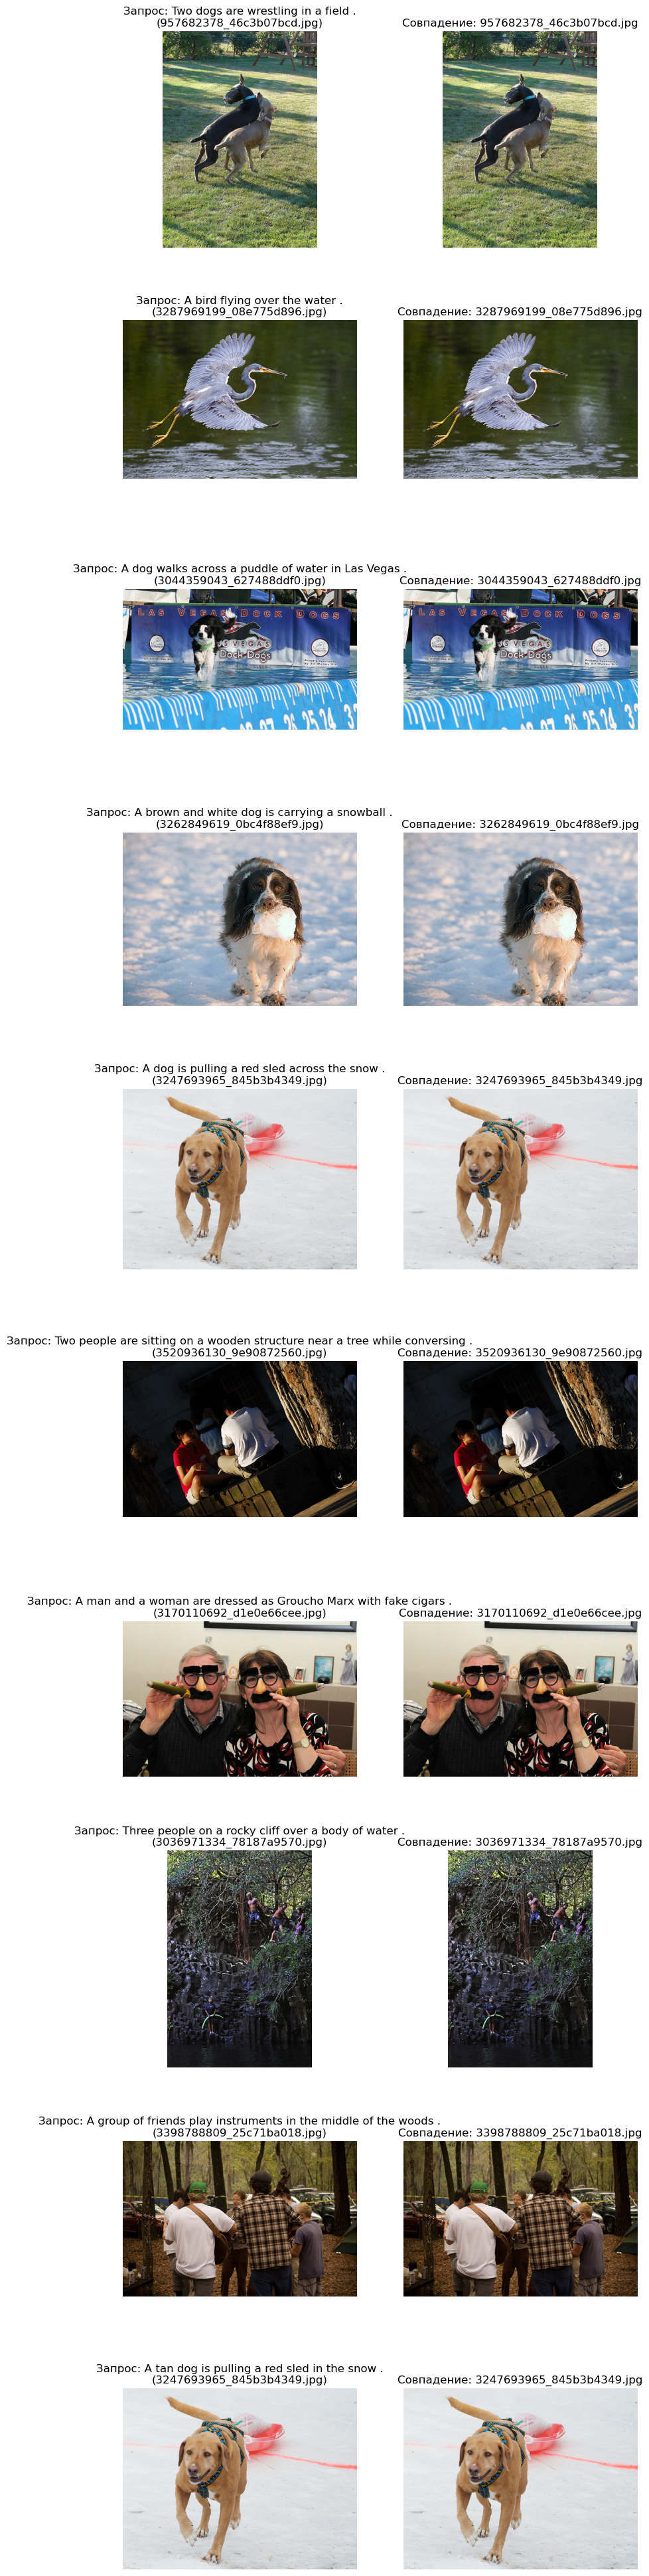

In [153]:
fig, axes = plt.subplots(len(results), 2, figsize=(10, 5 * len(results)))

for i, (query_id, matched_image) in enumerate(results):
    query_image_name = query_id.split('#')[0]
    matched_image_name = matched_image.split('#')[0]

    query_image_path = os.path.join(test_image_folder, query_image_name)
    matched_image_path = os.path.join(test_image_folder, matched_image_name)

    query_text = test_queries.loc[test_queries['query_id'] == query_id, 'query_text'].values[0]

    query_img = Image.open(query_image_path)
    matched_img = Image.open(matched_image_path)
    
    axes[i, 0].imshow(query_img)
    axes[i, 0].set_title(f"Запрос: {query_text}\n({query_image_name})")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(matched_img)
    axes[i, 1].set_title(f"Совпадение: {matched_image_name}")
    axes[i, 1].axis("off")

plt.show()

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
В процессе тестирования ты показываешь просто шикарное качество угадывания картинок. Все изображения идеально соответствуют описаниям.
    
Но по опыту работы с этим проектом скажу тебе, что достигается это не потому, что модель такая хорошая, а потому что в тестовом датасете все изображения идеально подходят друг другу. А твой выбор ограничен только парами из тестового датасета.
    
Поэтому  я попрошу тебя немного переделать логику инференса.
    
Во первых, нужно заранее векторизовать 100 уникальных тестовых изображений.    
    
Далее нужно написать функцию, способную искать изображение по тексту для одного описания. Функция должна уметь работать с любым текстовым описанием.

Что должна делаь функция
    
   - Получать текст
   - Возвращать картинку и метрику близости.
   - Выдавать дисклеймер если запрос некорректный
    
Под капотом функция должна векторизовать полученный текст, и с помощью модели получить предсказание для 100 пар (вектор описания + вектор изображения), где вектор описания мы получили только что, а 100 векторов изображений получили заранее.
    
И дальше ищем изображение, для которого модель покажет максимальную метрику.
    
    
    
---
    
 А затем нужно 10 раз применить функцию к 10 случайным запросам. 
    
И не пугайся, если вдруг ты увидишь, что качества угадывания модели  близкое к рандомному угадыванию. К сожалению такое случается, но зато мы будем четко понимать, что функции для инференса работают корректно,  а вот модель "подкачала".    
    
</div>

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Идеи и альтернативные подходы</b>
  Если хочешь получить хорошо работающее решение без обучения, то можешь провести эксперимент с нейронной сетью CLIP от OPEN AI (это не обязательно, только если хочешь добиться хороших результатов в этом проекте).

  Про эту нейронку много где написано, но можешь посмотреть например вот здесь  https://habr.com/ru/post/539312/.

  А для написания  реализации наиболее удобной лично для меня оказалась библиотека sbert. https://www.sbert.net/examples/applications/image-search/README.html  
    
    
<hr>    
    
Также неплохо работает следующий подход без предобученных моделей (к тому же легко реализуемый).
    
    
Вместо того, чтобы подавать на вход модели изображение + текст и получать меру соответствия, поступаем по другому. 
    
На вход модели подаем вектор описания, а на выходе учимся предсказывать вектор изображения. 
    
По поводу метрик тут ситуация следующая. Точно работает следующий подход
    
  - берем метрику mse, но тогда нужно чтобы модель её уменьшала. А значит в обучении используем только пары заведомо сответствующие друг другу

Можно попробовать использовать косинусное расстояние, она позволяет использовать все данные (если есть соответствие то выдает 1, если нет то 0). 
    
Также можно попробовать усложнить модель, например и изображения и тексты отправлять в пространство размерностью 256 и уже в этом пространстве учиться их "сближать".
    
По поводу методов векторизации: я бы использовать resnet18 для изображений (размерность эмбеддинга избражения 512) и БЕРТ для текстов (768). 
    
   
</div>

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Заключительный комментарий</b>

Подведем итоги. Я вижу, что в целом с проектом ты справляешься, но есть ряд ошибок, которые нужно обязательно проработать.
    
Ключевое на текущем этапе - это исправить ошибки при подготовке признаков, обучить другие модели и разобраться с тестированием.
    
Также я очень советую рассматривать задачу предсказания степени близости как задачу регрессии, а не классификации.
    
Желтые комментарии на твое усмотрение. Но учитывая что пока наш подход "не взлетел" и нужно хоть что-то показать заказчику, попробуй показать возможный инференс с помщью CLIP. С библиотекой sentence-transformers это делается буквально в 10 строк.    
Жду твою работу на повторное ревью.
</div>

In [154]:
nlp = spacy.load("en_core_web_sm")

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def lematize_text(text):
    expanded_text = contractions.fix(text)
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', expanded_text).lower().replace('\n', ' ').replace('\r', ' ').replace('  ', ' ')
    doc = nlp(cleaned_text)
    lemmas = [token.lemma_ for token in doc]
    filtered_tokens = [word for word in lemmas if word not in stop_words]
    return " ".join(filtered_tokens)  


df_filtered_no_child.loc[:,'lemmatized_text'] = df_filtered_no_child['query_text'].apply(lematize_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a.kuznecov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\a.kuznecov\AppData\Local\Temp\ipykernel_2696\1258563661.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_no_child.loc[:,'lemmatized_text'] = df_filtered_no_child['query_text'].apply(lematize_text)
